In [1]:
# Imports for data-preprocessing
import pandas as pd
import numpy as np
from __future__ import print_function

# Import for spliting the data set
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler

# Imports for classificaiton 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA 
from sklearn.pipeline import Pipeline
from sklearn import metrics as mt
import matplotlib.pyplot as plt

# Import for Statistical Comparison 
import math

Classification to predict *Income* using the following methods: RandomForest, K-Nearest Neighbors, and Decision Trees


In [2]:
# Import data
df = pd.read_csv('../data/master.csv')

In [5]:
df.head()

,Unnamed: 0,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_binary,condensed_education,continent,condensed_marital,condensed_workclass
0,0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,Bachelors,United States,Never,Government
1,1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,Bachelors,United States,Married,Self-Employed
2,2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,High School Graduate,United States,Divorced/Separated,Private
3,3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,No High School Diploma,United States,Married,Private
4,4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,Bachelors,Caribbean,Married,Private


In [3]:
# Delete unwanted variables
del df['workclass']
del df['education']
del df['education_num']
del df['marital_status']
del df['occupation']
del df['native_country'] 
del df['Unnamed: 0']

In [4]:
# Check data 
df.head()

,age,relationship,race,sex,capital_gain,capital_loss,hours_per_week,income_binary,condensed_education,continent,condensed_marital,condensed_workclass
0,39,Not-in-family,White,Male,2174,0,40,<=50K,Bachelors,United States,Never,Government
1,50,Husband,White,Male,0,0,13,<=50K,Bachelors,United States,Married,Self-Employed
2,38,Not-in-family,White,Male,0,0,40,<=50K,High School Graduate,United States,Divorced/Separated,Private
3,53,Husband,Black,Male,0,0,40,<=50K,No High School Diploma,United States,Married,Private
4,28,Wife,Black,Female,0,0,40,<=50K,Bachelors,Caribbean,Married,Private


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 12 columns):
age                    48842 non-null int64
relationship           48842 non-null object
race                   48842 non-null object
sex                    48842 non-null object
capital_gain           48842 non-null int64
capital_loss           48842 non-null int64
hours_per_week         48842 non-null int64
income_binary          48842 non-null object
condensed_education    48842 non-null object
continent              48842 non-null object
condensed_marital      48842 non-null object
condensed_workclass    48842 non-null object
dtypes: int64(4), object(8)
memory usage: 4.5+ MB


### Training and Testing Split

The goal of performing cross-validation is to split your data into a training set and test set. The training set is split up into multiple validation sets. We are going to use stratified K-fold cross-validation with 10 splits (K=10) for our classification tasks. This is because our data is unbalanced. There is a total of 48,842 individuals that were surveyed in our data set. Out of all the individuals surveyed, 41,762 are white, 32,650 are male, 37,155 have an income greater than or equal to 50K USD, 43,832 are from the United States, and 33,906 work in the private industry. Stratified K-fold cross-validation ensures that each of our training sets contains an equal proportion of each unbalanced variable. 

In [6]:
df.describe(exclude=[np.number])

,relationship,race,sex,income_binary,condensed_education,continent,condensed_marital,condensed_workclass
count,48842,48842,48842,48842,48842,48842,48842,48842
unique,6,5,2,2,7,9,4,4
top,Husband,White,Male,<=50K,High School Graduate,United States,Married,Private
freq,19716,41762,32650,37155,15784,43832,23044,33906


In [4]:
# Split the data into traning (80%) and test set (20%)
# We are using stratified cross validation here because the majority of the
#    individuals in the variable race are white

if 'income_binary' in df:
    y = df['income_binary'].values #get values we need 
    del df['income_binary']        #get rid of the class label
    X = df.values                  #use everything else to predict 
    
X = pd.get_dummies(df).values

# Scale attributes by the training set
scl = StandardScaler()
X = scl.fit_transform(X)

# Split the data into 20% Test and 80% Train using StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.20, random_state=111)
sss.get_n_splits(X, y) #retreving the splits 

C:\Users\TMccw\Anaconda2\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


10

In [8]:
print(sss)

StratifiedShuffleSplit(n_splits=10, random_state=111, test_size=0.2,
            train_size=None)


In [5]:
# Create a for loop that grabs the values for each fold for traing and test sets
for train_index, test_index in sss.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

TRAIN: [15163 16279 29246 ..., 21159 41049 17832] TEST: [43578  1917 17027 ..., 22163 39121  5217]
TRAIN: [12894 40784 33210 ..., 40386 25846 36294] TEST: [22078 13800    49 ..., 31283 31586  5940]
TRAIN: [16738 39693 30388 ...,   328 33912 39362] TEST: [24310 48705 25069 ..., 47258 14625 39292]
TRAIN: [ 7391 39777 43398 ...,  8978 24399 34458] TEST: [ 8836  1328 27156 ..., 47164 10476 15648]
TRAIN: [16863 33361 41054 ..., 26744 47828 11941] TEST: [18495 35842 20752 ..., 46535  4696 46808]
TRAIN: [ 5743 21257 30549 ...,  5927  7506 19162] TEST: [21737 30911  7484 ..., 19717 27662 19780]
TRAIN: [18797 40559 21393 ..., 47376 19268 42562] TEST: [13861 34766  4320 ..., 42723 30153 11994]
TRAIN: [36977 11147 24500 ..., 40130 15262 22626] TEST: [13974 35810 43678 ...,  7735 14376 40480]
TRAIN: [32752 37107 19197 ..., 26015 32870  7076] TEST: [36370 13966 29812 ..., 20543 23045 34324]
TRAIN: [22441 41471 48039 ..., 32784  4446 45905] TEST: [  934  1627 37667 ...,  4950 44845 21169]


In [6]:
# Classification with KNN on income_binary

# Create reusable KNN object 
KNN = KNeighborsClassifier(n_neighbors=25)

iter_num=0
# the indices are the rows used for training and testing in each iteration
for train_indices, test_indices in sss.split(X,y): 
    X_train = X[train_indices]  # train indices for X
    y_train = y[train_indices]  # train indices for y
    
    X_test = X[test_indices]    # test indices for X
    y_test = y[test_indices]    # test indices for y
    
    # train the reusable KNN classifier on the training data
    KNN.fit(X_train,y_train)  # train object
    y_hat = KNN.predict(X_test) # get test set precitions
    
    # Accuracy for the iterations of training/testing
    accuracy_KNN = mt.accuracy_score(y_test,y_hat)  # obtain accuracies for each iteration 
    print("----Iteration",iter_num," ----")         # print out each numbered interation 
    print('KNN accuracy =', accuracy_KNN)            

    #Metric report 
    metrics_KNN = classification_report(y_test,y_hat)  # obtain metric's report for each iteration 
    print('KNN metric report')
    print(metrics_KNN)
    iter_num+=1  # run through the first iteration, then second, then third ... then tenth

----Iteration 0  ----
KNN accuracy = 0.83539768656
KNN metric report
             precision    recall  f1-score   support

      <=50K       0.87      0.93      0.90      7431
       >50K       0.70      0.54      0.61      2338

avg / total       0.83      0.84      0.83      9769

----Iteration 1  ----
KNN accuracy = 0.839389906848
KNN metric report
             precision    recall  f1-score   support

      <=50K       0.87      0.93      0.90      7431
       >50K       0.71      0.56      0.63      2338

avg / total       0.83      0.84      0.83      9769

----Iteration 2  ----
KNN accuracy = 0.833145664858
KNN metric report
             precision    recall  f1-score   support

      <=50K       0.87      0.92      0.89      7431
       >50K       0.69      0.56      0.61      2338

avg / total       0.82      0.83      0.83      9769

----Iteration 3  ----
KNN accuracy = 0.830791278534
KNN metric report
             precision    recall  f1-score   support

      <=50K       0.87

In [7]:
# Get the mean accuracy

# Load the accuracies
accuracies_KNN = cross_val_score(KNN, X, y=y, cv=sss) # this also can help with parallelism

# Print out the mean 
mean_KNN = np.mean(accuracies_KNN)
print("The mean accuracy for this model is ", mean_KNN)

The mean accuracy for this model is  0.835510287645


In [11]:
# Lets train a PipeLine with PCA to see if we can increase the accuracy 

# First we need to set up the PipeLine that will take the PCA and then fit a KNN classifier
KNN_pipe = Pipeline([('PCA',PCA(n_components=2,svd_solver='randomized')),
     ('KNN',KNeighborsClassifier(n_neighbors=25))])

# Next we need to iterate through and get the prediction, like we did above
iter_num=0
# the indices are the rows used for training and testing in each iteration
for train_indices, test_indices in sss.split(X,y): 
    X_train = X[train_indices]  # train indices for X
    y_train = y[train_indices]  # train indices for y
    
    X_test = X[test_indices]    # test indices for X
    y_test = y[test_indices]    # test indices for y
    
    # train the reusable KNN classifier on the training data
    KNN_pipe.fit(X_train,y_train)    # train object
    y_hat = KNN_pipe.predict(X_test) # get test set precitions
    
    # accuracy for the iterations of training/testing
    accuracy_KNN_pipe = mt.accuracy_score(y_test,y_hat)  # obtain accuracies for each iteration 
    print("----Iteration",iter_num," ----")              # print out each numbered interation 
    print('KNN PipeLine accuracy =', accuracy_KNN_pipe)
    
    #Metric report 
    metrics_KNN_pipe = classification_report(y_test,y_hat)  # obtain metric's report for each iteration 
    print('KNN & PCA metric report')
    print(metrics_KNN_pipe)
    iter_num+=1  # run through the first iteration, then second, then third ... then tenth

----Iteration 0  ----
KNN PipeLine accuracy = 0.810727812468
KNN & PCA metric report
             precision    recall  f1-score   support

      <=50K       0.85      0.92      0.88      7431
       >50K       0.64      0.48      0.55      2338

avg / total       0.80      0.81      0.80      9769

----Iteration 1  ----
KNN PipeLine accuracy = 0.814515303511
KNN & PCA metric report
             precision    recall  f1-score   support

      <=50K       0.85      0.92      0.88      7431
       >50K       0.65      0.48      0.55      2338

avg / total       0.80      0.81      0.80      9769

----Iteration 2  ----
KNN PipeLine accuracy = 0.812468011055
KNN & PCA metric report
             precision    recall  f1-score   support

      <=50K       0.85      0.91      0.88      7431
       >50K       0.64      0.50      0.56      2338

avg / total       0.80      0.81      0.80      9769

----Iteration 3  ----
KNN PipeLine accuracy = 0.811034906336
KNN & PCA metric report
             pr

Next we are going to use a different classifier, Random Forest, to see if we can improve our accuracy and also control over-fitting.

In [12]:
# Get the mean accuracy

# Load the accuracies
accuracies_KNN_pipe = cross_val_score(KNN_pipe, X, y=y, cv=sss) # this also can help with parallelism

# Print out the mean 
mean_KNN_pipe = np.mean(accuracies_KNN_pipe)
print("The mean accuracy for this model is ", mean_KNN_pipe)

The mean accuracy for this model is  0.812519193367


In [13]:
# Accuracies for comparision for each KNN model 

# KNN model 1
print("1. The mean accuracy for KNN model is ", mean_KNN)
print('------------------------------------------------------------------------')

# RF model 2
print("2. The mean accuracy for KNN with PCA model is ", mean_KNN_pipe)
print('------------------------------------------------------------------------')

1. The mean accuracy for KNN model is  0.835510287645
------------------------------------------------------------------------
2. The mean accuracy for KNN with PCA model is  0.812519193367
------------------------------------------------------------------------


The mean accuracy for the K-Nearest Neighbor model without the PCA is 83.55%. This is the model we are going to choose for this classifier. Next, we will run a Random Forest classifier and then compare the two classifiers together to see which one generates the highest accuracy for our data.

In [14]:
# Classification with RandomForest

# No parameter adjustments

RF = RandomForestClassifier(random_state=111)

# Now we want to iterate through and grab the prediction, just like we did in the KNN above
iter_num=0
# the indices are the rows used for training and testing in each iteration
for train_indices, test_indices in sss.split(X,y): 
    X_train = X[train_indices]  # train indices for X
    y_train = y[train_indices]  # train indices for y
    
    X_test = X[test_indices]    # test indices for X
    y_test = y[test_indices]    # test indices for y
    
    # train the reusable KNN classifier on the training data
    RF.fit(X_train,y_train)  # train object
    y_hat = RF.predict(X_test) # get test set precitions
    
    # Accuracy for the iterations of training/testing
    accuracy_RF = mt.accuracy_score(y_test,y_hat)    # obtain accuracies for each iteration 
    print("----Iteration",iter_num," ----")          # print out each numbered interation 
    print('RF accuracy =', accuracy_RF)

    # Metric report 
    metrics_RF = classification_report(y_test,y_hat)
    print('RF metric report')
    print(metrics_RF)
    iter_num+=1


----Iteration 0  ----
RF accuracy = 0.838570989866
RF metric report
             precision    recall  f1-score   support

      <=50K       0.88      0.91      0.90      7431
       >50K       0.69      0.60      0.64      2338

avg / total       0.83      0.84      0.83      9769

----Iteration 1  ----
RF accuracy = 0.839901729962
RF metric report
             precision    recall  f1-score   support

      <=50K       0.88      0.92      0.90      7431
       >50K       0.69      0.60      0.64      2338

avg / total       0.83      0.84      0.84      9769

----Iteration 2  ----
RF accuracy = 0.83724024977
RF metric report
             precision    recall  f1-score   support

      <=50K       0.88      0.91      0.90      7431
       >50K       0.68      0.60      0.64      2338

avg / total       0.83      0.84      0.83      9769

----Iteration 3  ----
RF accuracy = 0.840720646944
RF metric report
             precision    recall  f1-score   support

      <=50K       0.88      0.

In [15]:
# Get the mean accuracy

# Load the accuracies
accuracies_RF = cross_val_score(RF, X, y=y, cv=sss) # this also can help with parallelism

# Print out the mean 
mean_RF = np.mean(accuracies_RF)
print("The mean accuracy for this model is ", mean_RF)

The mean accuracy for this model is  0.83975841949


The model below will incorporate a few parameter adjustments. First, we will add a max depth which is the max depth of the tree. When this is not added to the model parameters, the nodes are expanded until all leaves are pure. 

In [16]:
# Create an object that holds the second RF model with parameter adjustments

RF2= RandomForestClassifier(max_depth=10, random_state=111)

# Now we want to iterate through and grab the prediction, just like we did in the RF above
# Now we want to iterate through and grab the prediction, just like we did in the KNN above
iter_num=0
# the indices are the rows used for training and testing in each iteration
for train_indices, test_indices in sss.split(X,y): 
    X_train = X[train_indices]  # train indices for X
    y_train = y[train_indices]  # train indices for y
    
    X_test = X[test_indices]    # test indices for X
    y_test = y[test_indices]    # test indices for y
    
    # train the reusable KNN classifier on the training data
    RF2.fit(X_train,y_train)  # train object
    y_hat = RF2.predict(X_test) # get test set precitions
    
    # Accuracy for the iterations of training/testing
    accuracy_RF2 = mt.accuracy_score(y_test,y_hat)   # obtain accuracies for each iteration 
    print("----Iteration",iter_num," ----")          # print out each numbered interation 
    print('RF2 accuracy =', accuracy_RF2)

    # Metric report 
    metrics_RF2 = classification_report(y_test,y_hat)
    print('RF2 metric report')
    print(metrics_RF2)
    iter_num+=1

----Iteration 0  ----
RF2 accuracy = 0.853311495547
RF2 metric report
             precision    recall  f1-score   support

      <=50K       0.87      0.95      0.91      7431
       >50K       0.77      0.55      0.64      2338

avg / total       0.85      0.85      0.84      9769

----Iteration 1  ----
RF2 accuracy = 0.858532091309
RF2 metric report
             precision    recall  f1-score   support

      <=50K       0.87      0.95      0.91      7431
       >50K       0.79      0.55      0.65      2338

avg / total       0.85      0.86      0.85      9769

----Iteration 2  ----
RF2 accuracy = 0.854642235643
RF2 metric report
             precision    recall  f1-score   support

      <=50K       0.87      0.96      0.91      7431
       >50K       0.80      0.53      0.63      2338

avg / total       0.85      0.85      0.84      9769

----Iteration 3  ----
RF2 accuracy = 0.851161838469
RF2 metric report
             precision    recall  f1-score   support

      <=50K       0.8

In [17]:
# Get the mean accuracy

# Load the accuracies
accuracies_RF2 = cross_val_score(RF2, X, y=y, cv=sss) # this also can help with parallelism

# Print out the mean 
mean_RF2 = np.mean(accuracies_RF2)
print("The mean accuracy for this model is ", mean_RF2)

The mean accuracy for this model is  0.855113112908


In [19]:
# Create an object that holds the third RF model with parameter adjustments

RF3 = RandomForestClassifier(max_depth=20, random_state=111)

# Now we want to iterate through and grab the prediction, just like we did in the RF2 above
iter_num=0
# The indices are the rows used for training and testing in each iteration
for train_indices, test_indices in sss.split(X,y): 
    X_train = X[train_indices]  #train indices for X
    y_train = y[train_indices]  #train indices for y
    
    X_test = X[test_indices]    #test indices for X
    y_test = y[test_indices]    #test indices for y
    
    # Train the reusable KNN classifier on the training data
    RF3.fit(X_train,y_train)  # train object
    y_hat = RF3.predict(X_test) #get the test set predictions 
    
    # Accuracy for the iterations of training/testing
    accuracy_RF3= mt.accuracy_score(y_test,y_hat)    # obtain accuracies for each iteration 
    print("----Iteration",iter_num," ----")          # print out each numbered interation 
    print('RF3 accuracy =', accuracy_RF3)

    # Metric report 
    metrics_RF3 = classification_report(y_test,y_hat)
    print('RF3 metric report')
    print(metrics_RF3)
    iter_num+=1

----Iteration 0  ----
RF3 accuracy = 0.855665881871
RF3 metric report
             precision    recall  f1-score   support

      <=50K       0.87      0.95      0.91      7431
       >50K       0.77      0.57      0.65      2338

avg / total       0.85      0.86      0.85      9769

----Iteration 1  ----
RF3 accuracy = 0.860681748388
RF3 metric report
             precision    recall  f1-score   support

      <=50K       0.88      0.94      0.91      7431
       >50K       0.77      0.60      0.67      2338

avg / total       0.85      0.86      0.85      9769

----Iteration 2  ----
RF3 accuracy = 0.850035827618
RF3 metric report
             precision    recall  f1-score   support

      <=50K       0.88      0.93      0.90      7431
       >50K       0.73      0.59      0.65      2338

avg / total       0.84      0.85      0.84      9769

----Iteration 3  ----
RF3 accuracy = 0.850035827618
RF3 metric report
             precision    recall  f1-score   support

      <=50K       0.8

In [20]:
# Get the mean accuracy

# Load the accuracies
accuracies_RF3 = cross_val_score(RF3, X, y=y, cv=sss) # this also can help with parallelism

# Print out the mean 
mean_RF3 = np.mean(accuracies_RF3)
print("The mean accuracy for this model is ", mean_RF3)

The mean accuracy for this model is  0.854273723001


In [21]:
# Create an object that holds the third RF model with parameter adjustments

RF4 = RandomForestClassifier(max_depth=100, random_state=111)

# Now we want to iterate through and grab the prediction, just like we did in the RF3 above
iter_num=0
# The indices are the rows used for training and testing in each iteration
for train_indices, test_indices in sss.split(X,y): 
    X_train = X[train_indices]  #train indices for X
    y_train = y[train_indices]  #train indices for y
    
    X_test = X[test_indices]    #test indices for X
    y_test = y[test_indices]    #test indices for y
    
    # Train the reusable KNN classifier on the training data
    RF4.fit(X_train,y_train)  # train object
    y_hat = RF4.predict(X_test) #get the test set predictions 
    
    # Accuracy for the iterations of training/testing
    accuracy_RF4= mt.accuracy_score(y_test,y_hat)    # obtain accuracies for each iteration 
    print("----Iteration",iter_num," ----")          # print out each numbered interation 
    print('RF4 accuracy =', accuracy_RF4)

    # Metric report 
    metrics_RF4 = classification_report(y_test,y_hat)
    print('RF4 metric report')
    print(metrics_RF4)
    iter_num+=1

----Iteration 0  ----
RF4 accuracy = 0.838570989866
RF4 metric report
             precision    recall  f1-score   support

      <=50K       0.88      0.91      0.90      7431
       >50K       0.69      0.60      0.64      2338

avg / total       0.83      0.84      0.83      9769

----Iteration 1  ----
RF4 accuracy = 0.839901729962
RF4 metric report
             precision    recall  f1-score   support

      <=50K       0.88      0.92      0.90      7431
       >50K       0.69      0.60      0.64      2338

avg / total       0.83      0.84      0.84      9769

----Iteration 2  ----
RF4 accuracy = 0.83724024977
RF4 metric report
             precision    recall  f1-score   support

      <=50K       0.88      0.91      0.90      7431
       >50K       0.68      0.60      0.64      2338

avg / total       0.83      0.84      0.83      9769

----Iteration 3  ----
RF4 accuracy = 0.840720646944
RF4 metric report
             precision    recall  f1-score   support

      <=50K       0.88

In [22]:
# Get the mean accuracy

# Load the accuracies
accuracies_RF4 = cross_val_score(RF4, X, y=y, cv=sss) # this also can help with parallelism

# Print out the mean 
mean_RF4 = np.mean(accuracies_RF4)
print("The mean accuracy for this model is ", mean_RF4)

The mean accuracy for this model is  0.83975841949


In [23]:
# Create an object that holds the third RF model with parameter adjustments

RF5 = RandomForestClassifier(max_depth=50, random_state=111)

# Now we want to iterate through and grab the prediction, just like we did in the RF4 above
iter_num=0
# The indices are the rows used for training and testing in each iteration
for train_indices, test_indices in sss.split(X,y): 
    X_train = X[train_indices]  #train indices for X
    y_train = y[train_indices]  #train indices for y
    
    X_test = X[test_indices]    #test indices for X
    y_test = y[test_indices]    #test indices for y
    
    # Train the reusable KNN classifier on the training data
    RF5.fit(X_train,y_train)  # train object
    y_hat = RF5.predict(X_test) #get the test set predictions 
    
    # Accuracy for the iterations of training/testing
    accuracy_RF5= mt.accuracy_score(y_test,y_hat)    # obtain accuracies for each iteration 
    print("----Iteration",iter_num," ----")          # print out each numbered interation 
    print('RF5 accuracy =', accuracy_RF5)

    # Metric report 
    metrics_RF5 = classification_report(y_test,y_hat)
    print('RF5 metric report')
    print(metrics_RF5)
    iter_num+=1

----Iteration 0  ----
RF5 accuracy = 0.838468625243
RF5 metric report
             precision    recall  f1-score   support

      <=50K       0.88      0.91      0.90      7431
       >50K       0.69      0.60      0.64      2338

avg / total       0.83      0.84      0.83      9769

----Iteration 1  ----
RF5 accuracy = 0.840004094585
RF5 metric report
             precision    recall  f1-score   support

      <=50K       0.88      0.92      0.90      7431
       >50K       0.69      0.60      0.64      2338

avg / total       0.83      0.84      0.84      9769

----Iteration 2  ----
RF5 accuracy = 0.836626062033
RF5 metric report
             precision    recall  f1-score   support

      <=50K       0.88      0.91      0.89      7431
       >50K       0.68      0.59      0.64      2338

avg / total       0.83      0.84      0.83      9769

----Iteration 3  ----
RF5 accuracy = 0.840823011567
RF5 metric report
             precision    recall  f1-score   support

      <=50K       0.8

In [24]:
# Get the mean accuracy

# Load the accuracies
accuracies_RF5 = cross_val_score(RF5, X, y=y, cv=sss) # this also can help with parallelism

# Print out the mean 
mean_RF5 = np.mean(accuracies_RF5)
print("The mean accuracy for this model is ", mean_RF5)

The mean accuracy for this model is  0.839615109018


In [25]:
# Create an object that holds the third RF model with parameter adjustments

RF6 = RandomForestClassifier(max_depth=25, random_state=111)

# Now we want to iterate through and grab the prediction, just like we did in the RF4 above
iter_num=0
# The indices are the rows used for training and testing in each iteration
for train_indices, test_indices in sss.split(X,y): 
    X_train = X[train_indices]  #train indices for X
    y_train = y[train_indices]  #train indices for y
    
    X_test = X[test_indices]    #test indices for X
    y_test = y[test_indices]    #test indices for y
    
    # Train the reusable KNN classifier on the training data
    RF6.fit(X_train,y_train)  # train object
    y_hat = RF6.predict(X_test) #get the test set predictions 
    
    # Accuracy for the iterations of training/testing
    accuracy_RF6= mt.accuracy_score(y_test,y_hat)    # obtain accuracies for each iteration 
    print("----Iteration",iter_num," ----")          # print out each numbered interation 
    print('RF6 accuracy =', accuracy_RF6)

    # Metric report 
    metrics_RF6 = classification_report(y_test,y_hat)
    print('RF6 metric report')
    print(metrics_RF6)
    iter_num+=1

----Iteration 0  ----
RF6 accuracy = 0.849933462995
RF6 metric report
             precision    recall  f1-score   support

      <=50K       0.88      0.93      0.90      7431
       >50K       0.73      0.59      0.65      2338

avg / total       0.84      0.85      0.84      9769

----Iteration 1  ----
RF6 accuracy = 0.853004401679
RF6 metric report
             precision    recall  f1-score   support

      <=50K       0.88      0.93      0.91      7431
       >50K       0.73      0.61      0.67      2338

avg / total       0.85      0.85      0.85      9769

----Iteration 2  ----
RF6 accuracy = 0.845838878084
RF6 metric report
             precision    recall  f1-score   support

      <=50K       0.88      0.93      0.90      7431
       >50K       0.71      0.59      0.65      2338

avg / total       0.84      0.85      0.84      9769

----Iteration 3  ----
RF6 accuracy = 0.843893950251
RF6 metric report
             precision    recall  f1-score   support

      <=50K       0.8

In [26]:
# Get the mean accuracy

# Load the accuracies
accuracies_RF6 = cross_val_score(RF6, X, y=y, cv=sss) # this also can help with parallelism

# Print out the mean 
mean_RF6 = np.mean(accuracies_RF6)
print("The mean accuracy for this model is ", mean_RF6)

The mean accuracy for this model is  0.849032654315


In [27]:
# Accuracies for comparision for each RF model 

# RF model 1
print("1. The mean accuracy for RF model 1 is ", mean_RF)
print('------------------------------------------------------------------------')

# RF model 2
print("2. The mean accuracy for RF model 2 is ", mean_RF2)
print('------------------------------------------------------------------------')

# RF model 3
print("3. The mean accuracy for RF model 3 is ", mean_RF3)
print('------------------------------------------------------------------------')

# RF model 4
print("4. The mean accuracy for RF model 4 is ", mean_RF4)
print('------------------------------------------------------------------------')

# RF model 5
print("5. The mean accuracy for RF model 5 is ", mean_RF5)
print('------------------------------------------------------------------------')

# RF model 6
print("6. The mean accuracy for RF model 6 is ", mean_RF6)
print('------------------------------------------------------------------------')

1. The mean accuracy for RF model 1 is  0.83975841949
------------------------------------------------------------------------
2. The mean accuracy for RF model 2 is  0.855113112908
------------------------------------------------------------------------
3. The mean accuracy for RF model 3 is  0.854273723001
------------------------------------------------------------------------
4. The mean accuracy for RF model 4 is  0.83975841949
------------------------------------------------------------------------
5. The mean accuracy for RF model 5 is  0.839615109018
------------------------------------------------------------------------
6. The mean accuracy for RF model 6 is  0.849032654315
------------------------------------------------------------------------


In [7]:
# Create an object that holds the second RF model with parameter adjustments

RF2= RandomForestClassifier(max_depth=10, random_state=111)

# Now we want to iterate through and grab the prediction, just like we did in the RF above
# Now we want to iterate through and grab the prediction, just like we did in the KNN above
iter_num=0
# the indices are the rows used for training and testing in each iteration
for train_indices, test_indices in sss.split(X,y): 
    X_train = X[train_indices]  # train indices for X
    y_train = y[train_indices]  # train indices for y
    
    X_test = X[test_indices]    # test indices for X
    y_test = y[test_indices]    # test indices for y
    
    # train the reusable KNN classifier on the training data
    RF2.fit(X_train,y_train)  # train object
    y_hat = RF2.predict(X_test) # get test set precitions
    
    # Accuracy for the iterations of training/testing
    accuracy_RF2 = mt.accuracy_score(y_test,y_hat)   # obtain accuracies for each iteration 
    print("----Iteration",iter_num," ----")          # print out each numbered interation 
    print('RF2 accuracy =', accuracy_RF2)

    # Metric report 
    metrics_RF2 = classification_report(y_test,y_hat)
    print('RF2 metric report')
    print(metrics_RF2)
    iter_num+=1

----Iteration 0  ----
RF2 accuracy = 0.853311495547
RF2 metric report
             precision    recall  f1-score   support

      <=50K       0.87      0.95      0.91      7431
       >50K       0.77      0.55      0.64      2338

avg / total       0.85      0.85      0.84      9769

----Iteration 1  ----
RF2 accuracy = 0.858532091309
RF2 metric report
             precision    recall  f1-score   support

      <=50K       0.87      0.95      0.91      7431
       >50K       0.79      0.55      0.65      2338

avg / total       0.85      0.86      0.85      9769

----Iteration 2  ----
RF2 accuracy = 0.854642235643
RF2 metric report
             precision    recall  f1-score   support

      <=50K       0.87      0.96      0.91      7431
       >50K       0.80      0.53      0.63      2338

avg / total       0.85      0.85      0.84      9769

----Iteration 3  ----
RF2 accuracy = 0.851161838469
RF2 metric report
             precision    recall  f1-score   support

      <=50K       0.8

In [8]:
# Create an object that holds the third RF model with parameter adjustments
# The warm_start parameter reuses the solution of the previous model called and adds more estimators

RF7 = RandomForestClassifier(max_depth=10, random_state=111, n_estimators=150, warm_start=True)

# Now we want to iterate through and grab the prediction, just like we did in the RF2 above
iter_num=0
# The indices are the rows used for training and testing in each iteration
for train_indices, test_indices in sss.split(X,y): 
    X_train = X[train_indices]  #train indices for X
    y_train = y[train_indices]  #train indices for y
    
    X_test = X[test_indices]    #test indices for X
    y_test = y[test_indices]    #test indices for y
    
    # Train the reusable KNN classifier on the training data
    RF7.fit(X_train,y_train)  # train object
    y_hat = RF7.predict(X_test) #get the test set predictions 
    
    # Accuracy for the iterations of training/testing
    accuracy_RF7= mt.accuracy_score(y_test,y_hat)
    print("----Iteration",iter_num," ----")          # print out each numbered interation 
    print('RF7 accuracy =', accuracy_RF7)

    # Metric report 
    metrics_RF7 = classification_report(y_test,y_hat)
    print('RF7 metric report')
    print(metrics_RF7)
    iter_num+=1

----Iteration 0  ----
RF7 accuracy = 0.856382434231
RF7 metric report
             precision    recall  f1-score   support

      <=50K       0.86      0.96      0.91      7431
       >50K       0.81      0.52      0.64      2338

avg / total       0.85      0.86      0.84      9769



C:\Users\TMccw\Anaconda2\lib\site-packages\sklearn\ensemble\forest.py:303: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "


----Iteration 1  ----
RF7 accuracy = 0.864264510185
RF7 metric report
             precision    recall  f1-score   support

      <=50K       0.87      0.96      0.92      7431
       >50K       0.83      0.55      0.66      2338

avg / total       0.86      0.86      0.85      9769

----Iteration 2  ----
RF7 accuracy = 0.860988842256
RF7 metric report
             precision    recall  f1-score   support

      <=50K       0.87      0.96      0.91      7431
       >50K       0.82      0.54      0.65      2338

avg / total       0.86      0.86      0.85      9769

----Iteration 3  ----
RF7 accuracy = 0.853823318661
RF7 metric report
             precision    recall  f1-score   support

      <=50K       0.86      0.96      0.91      7431
       >50K       0.80      0.52      0.63      2338

avg / total       0.85      0.85      0.84      9769

----Iteration 4  ----
RF7 accuracy = 0.860374654519
RF7 metric report
             precision    recall  f1-score   support

      <=50K       0.8

In [9]:
# Get the mean accuracy

# Load the accuracies
accuracies_RF7 = cross_val_score(RF7, X, y=y, cv=sss) # this also can help with parallelism

# Print out the mean 
mean_RF7 = np.mean(accuracies_RF7)
print("The mean accuracy for this model is ", mean_RF7)

The mean accuracy for this model is  0.856771419797


In [45]:
# Create an object that holds the third RF model with parameter adjustments
# The warm_start parameter reuses the solution of the previous model called and adds more estimators

RF8 = RandomForestClassifier(max_depth=10, random_state=111, n_estimators=200, warm_start=True)

# Now we want to iterate through and grab the prediction, just like we did in the RF2 above
iter_num=0
# The indices are the rows used for training and testing in each iteration
for train_indices, test_indices in sss.split(X,y): 
    X_train = X[train_indices]  #train indices for X
    y_train = y[train_indices]  #train indices for y
    
    X_test = X[test_indices]    #test indices for X
    y_test = y[test_indices]    #test indices for y
    
    # Train the reusable KNN classifier on the training data
    RF8.fit(X_train,y_train)  # train object
    y_hat = RF8.predict(X_test) #get the test set predictions 
    
    # Accuracy for the iterations of training/testing
    accuracy_RF8= mt.accuracy_score(y_test,y_hat)
    print("----Iteration",iter_num," ----")          # print out each numbered interation 
    print('RF8 accuracy =', accuracy_RF8)

    # Metric report 
    metrics_RF8 = classification_report(y_test,y_hat)
    print('RF8 metric report')
    print(metrics_RF8)
    iter_num+=1

----Iteration 0  ----
RF8 accuracy = 0.856280069608
RF8 metric report
             precision    recall  f1-score   support

      <=50K       0.86      0.96      0.91      7431
       >50K       0.81      0.52      0.63      2338

avg / total       0.85      0.86      0.84      9769

----Iteration 1  ----
RF8 accuracy = 0.864366874808
RF8 metric report
             precision    recall  f1-score   support

      <=50K       0.87      0.96      0.92      7431
       >50K       0.83      0.55      0.66      2338

avg / total       0.86      0.86      0.85      9769

----Iteration 2  ----
RF8 accuracy = 0.861091206879
RF8 metric report
             precision    recall  f1-score   support

      <=50K       0.87      0.96      0.91      7431
       >50K       0.82      0.54      0.65      2338

avg / total       0.86      0.86      0.85      9769

----Iteration 3  ----
RF8 accuracy = 0.853004401679
RF8 metric report
             precision    recall  f1-score   support

      <=50K       0.8

In [46]:
# Get the mean accuracy

# Load the accuracies
accuracies_RF8 = cross_val_score(RF8, X, y=y, cv=sss) # this also can help with parallelism

# Print out the mean 
mean_RF8 = np.mean(accuracies_RF8)
print("The mean accuracy for this model is ", mean_RF8)

The mean accuracy for this model is  0.85664858225


In [47]:
# Accuracies for comparision for each RF model 

# RF model 1
print("1. The mean accuracy for RF model 1 is ", mean_RF)
print('------------------------------------------------------------------------')

# RF model 2
print("2. The mean accuracy for RF model 2 is ", mean_RF2)
print('------------------------------------------------------------------------')

# RF model 3
print("3. The mean accuracy for RF model 3 is ", mean_RF3)
print('------------------------------------------------------------------------')

# RF model 4
print("4. The mean accuracy for RF model 4 is ", mean_RF4)
print('------------------------------------------------------------------------')

# RF model 5
print("5. The mean accuracy for RF model 5 is ", mean_RF5)
print('------------------------------------------------------------------------')

# RF model 6
print("6. The mean accuracy for RF model 6 is ", mean_RF6)
print('------------------------------------------------------------------------')

# RF model 7
print("7. The mean accuracy for RF model 7 is ", mean_RF7)
print('------------------------------------------------------------------------')

# RF model 8
print("8. The mean accuracy for RF model 8 is ", mean_RF8)
print('------------------------------------------------------------------------')

1. The mean accuracy for RF model 1 is  0.83975841949
------------------------------------------------------------------------
2. The mean accuracy for RF model 2 is  0.855113112908
------------------------------------------------------------------------
3. The mean accuracy for RF model 3 is  0.854273723001
------------------------------------------------------------------------
4. The mean accuracy for RF model 4 is  0.83975841949
------------------------------------------------------------------------
5. The mean accuracy for RF model 5 is  0.839615109018
------------------------------------------------------------------------
6. The mean accuracy for RF model 6 is  0.849032654315
------------------------------------------------------------------------
7. The mean accuracy for RF model 7 is  0.856771419797
------------------------------------------------------------------------
8. The mean accuracy for RF model 8 is  0.85664858225
----------------------------------------------------

The Random Forest model with the highest predicted accuracy is model 7. Random Forest model 7 has a max tree depth of 10 and 150 estimators, which represents the number of trees in the forest. We have also included the *warm_start* hyperparameter to this model. This hyperparameter reuses the solution of the previous model called, which was RF model 2, and adds more estimators. 

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=150, n_jobs=1, oob_score=False, random_state=111,
            verbose=0, warm_start=True)


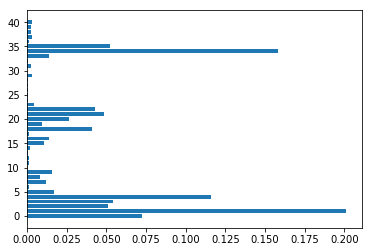

In [15]:
print (RF7)

plt.barh(range(len(RF7.feature_importances_)), RF7.feature_importances_)
plt.show()

Naive Bayes classification for *income_binary*

In [50]:
# Create an object that holds the NB

GNB = GaussianNB()

# Now we want to iterate through and grab the prediction, just like we did in the RF2 above
iter_num=0
# The indices are the rows used for training and testing in each iteration
for train_indices, test_indices in sss.split(X,y): 
    X_train = X[train_indices]  #train indices for X
    y_train = y[train_indices]  #train indices for y
    
    X_test = X[test_indices]    #test indices for X
    y_test = y[test_indices]    #test indices for y
    
    # Train the reusable KNN classifier on the training data
    GNB.fit(X_train,y_train)  # train object
    y_hat = GNB.predict(X_test) #get the test set predictions 
    
    # Accuracy for the iterations of training/testing
    accuracy_GNB= mt.accuracy_score(y_test,y_hat)
    print("----Iteration",iter_num," ----")          # print out each numbered interation 
    print('GNB accuracy =', accuracy_GNB)

    # Metric report 
    metrics_GNB = classification_report(y_test,y_hat)
    print('GNB metric report')
    print(metrics_GNB)
    iter_num+=1

----Iteration 0  ----
GNB accuracy = 0.768655952503
GNB metric report
             precision    recall  f1-score   support

      <=50K       0.95      0.74      0.83      7431
       >50K       0.51      0.86      0.64      2338

avg / total       0.84      0.77      0.78      9769

----Iteration 1  ----
GNB accuracy = 0.767018118538
GNB metric report
             precision    recall  f1-score   support

      <=50K       0.95      0.74      0.83      7431
       >50K       0.51      0.87      0.64      2338

avg / total       0.84      0.77      0.78      9769

----Iteration 2  ----
GNB accuracy = 0.759136042584
GNB metric report
             precision    recall  f1-score   support

      <=50K       0.94      0.73      0.82      7431
       >50K       0.50      0.85      0.63      2338

avg / total       0.83      0.76      0.78      9769

----Iteration 3  ----
GNB accuracy = 0.769474869485
GNB metric report
             precision    recall  f1-score   support

      <=50K       0.9

In [51]:
# Get the mean accuracy

# Load the accuracies
accuracies_GNB = cross_val_score(GNB, X, y=y, cv=sss) # this also can help with parallelism

# Print out the mean 
mean_GNB = np.mean(accuracies_GNB)
print("The mean accuracy for this model is ", mean_GNB)

The mean accuracy for this model is  0.765871634763


In [10]:
# Create an object that holds the BNB classifier. 
# BernoulliNB is used because it is desgined for binary features

BNB = BernoulliNB()

# Now we want to iterate through and grab the prediction, just like we did in the RF2 above
iter_num=0
# The indices are the rows used for training and testing in each iteration
for train_indices, test_indices in sss.split(X,y): 
    X_train = X[train_indices]  #train indices for X
    y_train = y[train_indices]  #train indices for y
    
    X_test = X[test_indices]    #test indices for X
    y_test = y[test_indices]    #test indices for y
    
    # Train the reusable KNN classifier on the training data
    BNB.fit(X_train,y_train)  # train object
    y_hat = BNB.predict(X_test) #get the test set predictions 
    
    # Accuracy for the iterations of training/testing
    accuracy_BNB= mt.accuracy_score(y_test,y_hat)
    print("----Iteration",iter_num," ----")          # print out each numbered interation 
    print('BNB accuracy =', accuracy_BNB)

    # Metric report 
    metrics_BNB = classification_report(y_test,y_hat)
    print('BNB metric report')
    print(metrics_BNB)
    iter_num+=1

----Iteration 0  ----
BNB accuracy = 0.744088443034
BNB metric report
             precision    recall  f1-score   support

      <=50K       0.92      0.73      0.81      7431
       >50K       0.48      0.79      0.60      2338

avg / total       0.81      0.74      0.76      9769

----Iteration 1  ----
BNB accuracy = 0.750127955778
BNB metric report
             precision    recall  f1-score   support

      <=50K       0.92      0.73      0.82      7431
       >50K       0.49      0.81      0.61      2338

avg / total       0.82      0.75      0.77      9769

----Iteration 2  ----
BNB accuracy = 0.742348244447
BNB metric report
             precision    recall  f1-score   support

      <=50K       0.91      0.73      0.81      7431
       >50K       0.48      0.78      0.59      2338

avg / total       0.81      0.74      0.76      9769

----Iteration 3  ----
BNB accuracy = 0.748490121814
BNB metric report
             precision    recall  f1-score   support

      <=50K       0.9

In [53]:
# Get the mean accuracy

# Load the accuracies
accuracies_BNB = cross_val_score(BNB, X, y=y, cv=sss) # this also can help with parallelism

# Print out the mean 
mean_BNB = np.mean(accuracies_BNB)
print("The mean accuracy for this model is ", mean_BNB)

The mean accuracy for this model is  0.747241273416


In [54]:
# Accuracy, Precision, Rcall, and F-score for comparision for each NB  

# GNB 
print("1. The mean accuracy for GNB model 1 is ", mean_GNB)
print('------------------------------------------------------------------------')

# BNB
print("1. The mean accuracy for BNB model 1 is ", mean_BNB)
print('------------------------------------------------------------------------')


1. The mean accuracy for GNB model 1 is  0.765871634763
------------------------------------------------------------------------
1. The mean accuracy for BNB model 1 is  0.747241273416
------------------------------------------------------------------------


For the Naive Bayes classifier, we are going to use the Bernoulli model because Bernoulli models are mainly used for classifying binary data. Even though the Gaussian model has a slightly higher accuracy, the Bernoulli is the correct model to choose for our given data. 

### Comparing K-Nearest Neighbor, Random Forest, and Naive Bayes. 

In [55]:
# Mean accuracies for the three different classification methods

# KNN model 1
print("1. The mean accuracy for KNN model is ", mean_KNN)
print('------------------------------------------------------------------------')

# RF model 7
print("2. The mean accuracy for RF model 7 is ", mean_RF7)
print('------------------------------------------------------------------------')

# BNB
print("3. The mean accuracy for BNB model 1 is ", mean_BNB)
print('------------------------------------------------------------------------')

1. The mean accuracy for KNN model is  0.835510287645
------------------------------------------------------------------------
2. The mean accuracy for RF model 7 is  0.856771419797
------------------------------------------------------------------------
3. The mean accuracy for BNB model 1 is  0.747241273416
------------------------------------------------------------------------


The Random Forest classifier has the highest mean predicted accuracy, 85.67%, when compared to the other two classification methods. K-Nearest Neighbor has the second highest mean predicted accuracy, 83.55%, while Bernoulli Navie Bayes classifier has the lowest mean predicted accuracy, 74.72%. 

### Statistical Comparison

Interpertation of the Confidence Interval 

We are 95% confident that the mean of the three models is between [-0.4352, -0.0279]. The interval does not include 0. This means that there is a significant difference between the three models. 

In [63]:
# Calculating the Error Rates of the three models 

# KNN Model
KNN_Accs = [83.53, 83.93, 83.31, 83.07, 83.30, 83.56, 83.78, 83.34, 83.75, 83.88]

iter_num=0
for x in KNN_Accs:
    KNN_ER = 100-x
    print("----Iteration",iter_num," ----") 
    print('KNN Error Rate =', KNN_ER)
    iter_num+=1

# RF Model 
RF_Accs = [85.63, 86.42, 86.09, 85.38, 86.03, 86.27, 86.23, 85.58, 86.04, 86.17]

iter_num=0
for x in RF_Accs:
    RF_ER = 100-x
    print("----Iteration",iter_num," ----") 
    print('RF Error Rate =', RF_ER)
    iter_num+=1
    
# BNB Model 
BNB_Accs = [74.40, 75.01, 74.23, 74.84, 75.10, 75.13, 74.83, 74.75, 74.05, 74.84]

iter_num=0
for x in BNB_Accs:
    BNB_ER = 100-x
    print("----Iteration",iter_num," ----") 
    print('BNB Error Rate =', BNB_ER)
    iter_num+=1

----Iteration 0  ----
KNN Error Rate = 16.47
----Iteration 1  ----
KNN Error Rate = 16.07
----Iteration 2  ----
KNN Error Rate = 16.69
----Iteration 3  ----
KNN Error Rate = 16.93
----Iteration 4  ----
KNN Error Rate = 16.7
----Iteration 5  ----
KNN Error Rate = 16.44
----Iteration 6  ----
KNN Error Rate = 16.22
----Iteration 7  ----
KNN Error Rate = 16.66
----Iteration 8  ----
KNN Error Rate = 16.25
----Iteration 9  ----
KNN Error Rate = 16.12
----Iteration 0  ----
RF Error Rate = 14.37
----Iteration 1  ----
RF Error Rate = 13.58
----Iteration 2  ----
RF Error Rate = 13.91
----Iteration 3  ----
RF Error Rate = 14.62
----Iteration 4  ----
RF Error Rate = 13.97
----Iteration 5  ----
RF Error Rate = 13.73
----Iteration 6  ----
RF Error Rate = 13.77
----Iteration 7  ----
RF Error Rate = 14.42
----Iteration 8  ----
RF Error Rate = 13.96
----Iteration 9  ----
RF Error Rate = 13.83
----Iteration 0  ----
BNB Error Rate = 25.6
----Iteration 1  ----
BNB Error Rate = 24.99
----Iteration 2  ----


In [4]:
# Calculate the difference in the error rate bewteen each model comparsion
KNN_ER = np.array([16.47, 16.07, 16.69, 16.93, 16.7, 16.44, 16.22, 16.66, 16.25, 16.12])
RF_ER = np.array([14.37, 13.58, 13.91, 14.62, 13.97, 13.73, 13.77, 14.42, 13.96, 13.83])
BNB_ER = np.array([25.6, 24.99, 25.77, 25.16, 24.9, 24.87, 25.17, 25.25, 25.95, 25.16])

# KNN to RF 
Diff1 = KNN_ER - RF_ER
print(Diff1)

# KNN to BNB
Diff2 = KNN_ER - BNB_ER
print(Diff2)

# RF to BNB
Diff3 = RF_ER - BNB_ER
print(Diff3)

[ 2.1   2.49  2.78  2.31  2.73  2.71  2.45  2.24  2.29  2.29]
[-9.13 -8.92 -9.08 -8.23 -8.2  -8.43 -8.95 -8.59 -9.7  -9.04]
[-11.23 -11.41 -11.86 -10.54 -10.93 -11.14 -11.4  -10.83 -11.99 -11.33]


In [10]:
# Calculate the mean of the differance in Error Rates for each model comparison

# KNN to RF 
mean1 = np.mean(Diff1)
print(mean1)

# KNN to BNB
mean2 = np.mean(Diff2)
print(mean2)

# RF to BNB
mean3 = np.mean(Diff3)
print(mean3)

2.439
-8.827
-11.266


In [26]:
# Calculate the Variance of the differance in Error Rates for each model comparison
K = 10 

# KNN to RF 
for x in Diff1:
    y = x-mean1
    #print(y)

sumy = np.sum(y)
# print(sumy)

V = (1/K-1)*(sumy)
print('Variance for KNN & RF =', V)

# KNN to BNB
for x in Diff2:
    y2 = x-mean2
    #print(y)

sumy2 = np.sum(y2)
# print(sumy)

V2 = (1/K-1)*(sumy2)
print('Variance for KNN & BNB =', V2)

# RF to BNB
for x in Diff3:
    y3 = x-mean3
    #print(y)

sumy3 = np.sum(y3)
# print(sumy)

V3 = (1/K-1)*(sumy3)
print('Variance for RF & BNB =', V3)

Variance for KNN & RF = 0.149
Variance for KNN & BNB = 0.213
Variance for RF & BNB = 0.064


In [35]:
# Calculate the Confidence Intervals for each comparison
K = 10
t_stat = 1.812

# KNN to RF
l = 1/math.sqrt(K)*t_stat*V

CI_plus = mean1 + l
CI_minus = mean1 - l
print('Confidence Interval for KNN and RF is', CI_minus, CI_plus)

Confidence Interval for KNN and RF is 2.35362229791 2.52437770209


0.0853777020914
